In [2]:
import glob
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import numpy as np
from jwst.datamodels import dqflags
from scipy.ndimage import label, find_objects, center_of_mass, sum_labels


def main(xpos, ypos, size=100, filter='f480m', module='nrcblong', vgroup='3109', expnum='00001', visit='001' ):
    #jw06151001001_03109_00007_nrcblong_cal.fits
    imgdir = f'/orange/adamginsburg/jwst/w51/{filter.upper()}/'
    if filter in ['f140m', 'f162m', 'f182m', 'f187n', 'f210m', 'f335m', 'f360m', 'f410m', 'f430m', 'f444w', 'f460m', 'f480m']:

        img_filename = imgdir + '/pipeline/'+f'jw06151001001_0{vgroup}_{expnum}_{module}_cal.fits'
    else:
        img_filename = imgdir + '/pipeline/'+f'jw06151002{visit}_0{vgroup}_{expnum}_{module}_cal.fits'
    img = fits.open(img_filename)

    fig = plt.figure(figsize=(30,15))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    wcs_img = WCS(img[1].header)
    norm = simple_norm(img[1].data, 'sqrt', percent=99)
    ax1.imshow(img[1].data, norm=norm, origin='lower', cmap='inferno')
    square = plt.Rectangle((xpos - size/2, ypos - size/2), size, size, edgecolor='cyan', facecolor='none', lw=2)
    ax1.add_patch(square)
    ax1.set_title(f'Image: {img_filename}', fontsize=16)
    # f480m_nrcb_visit001_vgroup3109_exp00007_daophot_basic.fits
    wav = int(filter.lower()[1:4])
    """
    if wav > 300:
        module2 = module[:-4]  #nrca or nrcb
    else:
        module2 = module
    """
    module2 = module
    cat_basic_filename = imgdir + f'{filter.lower()}_{module2}_visit{visit}_vgroup0{vgroup}_exp{expnum}_daophot_basic.fits'
    cat_refined_filename = imgdir + f'{filter.lower()}_{module2}_visit{visit}_vgroup0{vgroup}_exp{expnum}_daophot_refined.fits'

    #jw06151001001_03109_00007_nrcblong_align_o001_crf_satstar_catalog_newnewnewnew.fits
    if filter in ['f140m', 'f162m', 'f182m', 'f187n', 'f210m', 'f335m', 'f360m', 'f410m', 'f430m', 'f444w', 'f460m', 'f480m']:
        sat_cat_filename = imgdir + '/pipeline/'+f'jw06151001001_0{vgroup}_{expnum}_{module}_align_o001_crf_satstar_catalog_newnewnewnew.fits'
    else:
        sat_cat_filename = imgdir + '/pipeline/'+f'jw06151002{visit}_0{vgroup}_{expnum}_{module}_cal_satstar_catalog_newnewnewnew.fits'
        #f480m_nrcalong_visit001_vgroup03109_exp00001_daophot_combined_with_satstars.fits
    cat_after_sat_filename = imgdir + f'{filter.lower()}_{module2}_visit{visit}_vgroup0{vgroup}_exp{expnum}_daophot_combined_with_satstars.fits'
    print(cat_after_sat_filename)
    print(cat_basic_filename)
    print(cat_refined_filename)
    print(sat_cat_filename)
    cat_after_sat = Table.read(cat_after_sat_filename)
    print('cat_after_sat.colnames', cat_after_sat.colnames)
    cutout_xmin = int(xpos - size/2)
    cutout_xmax = int(xpos + size/2)
    cutout_ymin = int(ypos - size/2)
    cutout_ymax = int(ypos + size/2)
    cutout = img[1].data[cutout_ymin:cutout_ymax, cutout_xmin:cutout_xmax]
    norm = simple_norm(cutout, 'sqrt', percent=99)

    ax2.imshow(cutout, norm=norm, origin='lower', cmap='inferno')
    ax2.set_title(f'Cutout centered at ({xpos}, {ypos})', fontsize=16)
    
    cat_basic = Table.read(cat_basic_filename)
    cat_refined = Table.read(cat_refined_filename)
    sat_cat = Table.read(sat_cat_filename)

    xpos_basic = cat_basic['x_fit']
    ypos_basic = cat_basic['y_fit']
    xpos_refined = cat_refined['x_fit']
    ypos_refined = cat_refined['y_fit']
    print(sat_cat.colnames)

    xpos_sat = sat_cat['xcentroid']
    ypos_sat = sat_cat['ycentroid']

    ra_after_sat = cat_after_sat['skycoord_centroid'].ra
    dec_after_sat = cat_after_sat['skycoord_centroid'].dec
    skycoord_after_sat = SkyCoord(ra_after_sat, dec_after_sat, unit='deg')
    x_after_sat, y_after_sat = wcs_img.world_to_pixel(skycoord_after_sat)
    ax1.scatter(xpos_sat, ypos_sat, s=500, edgecolor='red', facecolor='none', label='Saturated Stars Catalog', lw=2)

    ax2.scatter(xpos_basic-cutout_xmin, ypos_basic-cutout_ymin, s=300, edgecolor='blue', facecolor='none', label='Basic Catalog', lw=2)
    ax2.scatter(xpos_refined-cutout_xmin, ypos_refined-cutout_ymin, s=600, edgecolor='green', facecolor='none', label='Refined Catalog', lw=2)
    ax2.scatter(xpos_sat-cutout_xmin, ypos_sat-cutout_ymin, s=500, edgecolor='red', facecolor='none', label='Saturated Stars Catalog', lw=2)
    ax2.scatter(x_after_sat - cutout_xmin, y_after_sat - cutout_ymin, s=400, edgecolor='cyan', facecolor='none', label='After Adding Saturated Stars', lw=2)
    ax2.set_xlim(0, size)
    ax2.set_ylim(0, size)

    dqarr = fits.open(img_filename)['DQ'].data
    is_saturated = (dqarr & dqflags.pixel['SATURATED']) != 0
    labeled_array, num_features = label(is_saturated)
    centers = center_of_mass(is_saturated, labeled_array, range(1, num_features + 1))
    for center in centers:
        ycen, xcen = center
        if cutout_xmin <= xcen < cutout_xmax and cutout_ymin <= ycen < cutout_ymax:
            ax2.scatter(xcen - cutout_xmin, ycen - cutout_ymin, s=800, edgecolor='magenta', facecolor='none', label='Saturated Star Center', lw=2)
    return img['SCI'].data, img['ERR'].data, cutout




Set DATE-AVG to '2025-05-06T16:39:46.010' from MJD-AVG.
Set DATE-END to '2025-05-06T16:41:49.483' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -25.271880 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441530.624 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/orange/adamginsburg/jwst/w51/F480M/f480m_nrcblong_visit001_vgroup03109_exp00001_daophot_combined_with_satstars.fits
/orange/adamginsburg/jwst/w51/F480M/f480m_nrcblong_visit001_vgroup03109_exp00001_daophot_basic.fits
/orange/adamginsburg/jwst/w51/F480M/f480m_nrcblong_visit001_vgroup03109_exp00001_daophot_refined.fits
/orange/adamginsburg/jwst/w51/F480M//pipeline/jw06151001001_03109_00001_nrcblong_align_o001_crf_satstar_catalog_newnewnewnew.fits
cat_after_sat.colnames ['id', 'local_bkg', 'flux_fit', 'flux_err', 'qfit', 'cfit', 'roundness1', 'roundness2', 'sharpness', 'dra', 'ddec', 'from_sat_catalog', 'skycoord_centroid']
['id', 'group_id', 'group_size', 'local_bkg', 'x_init', 'y_init', 'flux_init', 'x_fit', 'y_fit', 'flux_fit', 'x_err', 'y_err', 'flux_err', 'npixfit', 'qfit', 'cfit', 'flags', 'xcentroid', 'ycentroid', 'skycoord_fit']


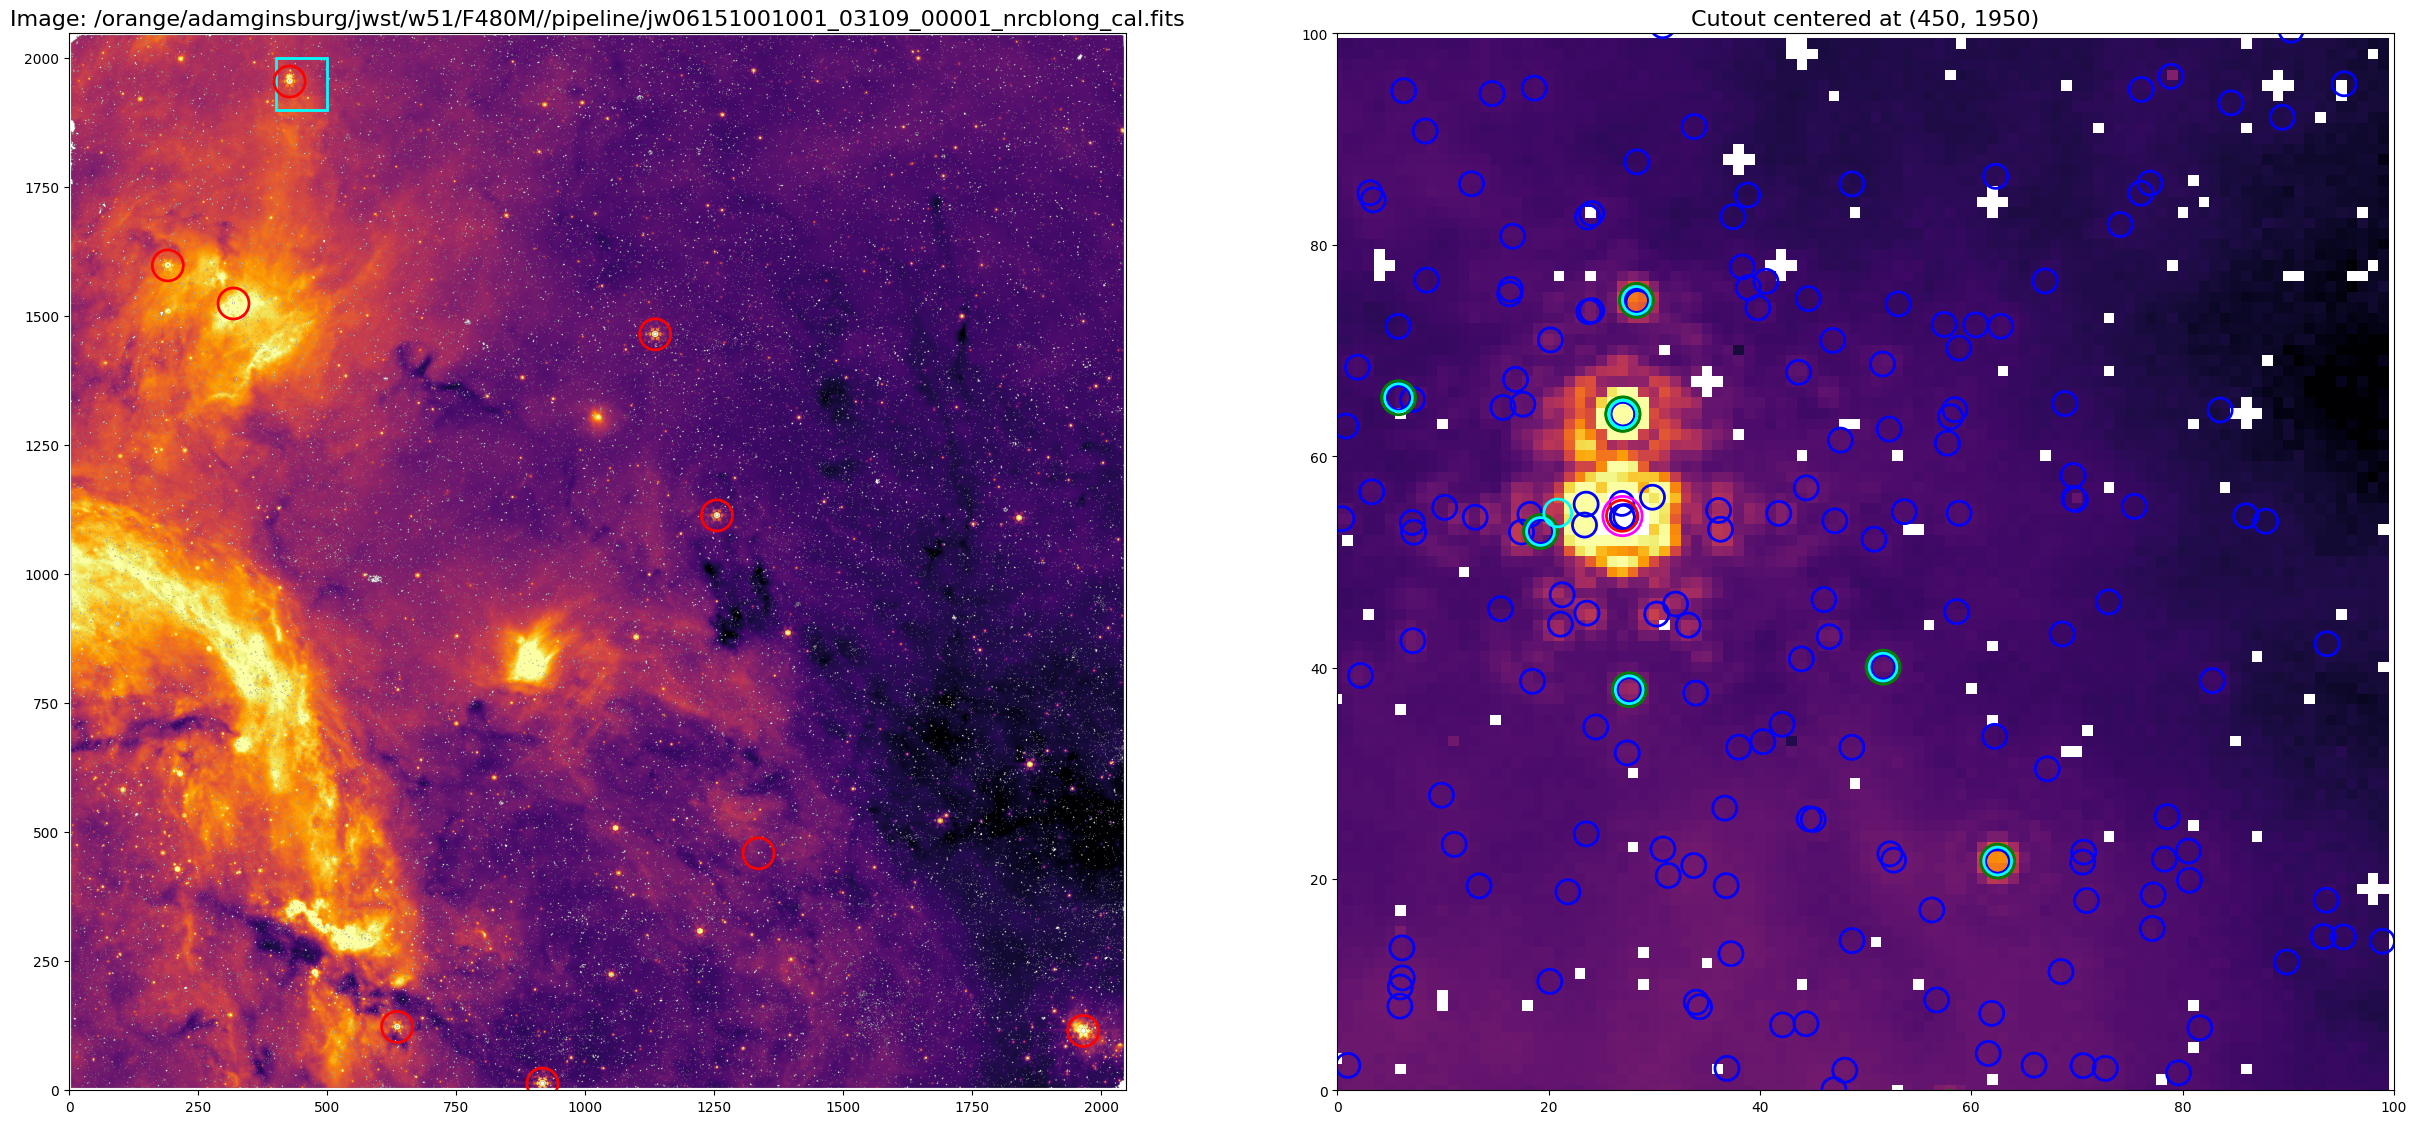

In [3]:
data, err, cutout = main(450, 1950, size=100, filter='f480m', module='nrcblong', vgroup='3109', expnum='00001' )   


Set DATE-AVG to '2024-09-08T11:45:59.416' from MJD-AVG.
Set DATE-END to '2024-09-08T11:46:06.354' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.737508 from OBSGEO-[XYZ].
Set OBSGEO-H to 1291406904.717 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/orange/adamginsburg/jwst/w51/F560W/f560w_mirimage_visit002_vgroup02101_exp00001_daophot_combined_with_satstars.fits
/orange/adamginsburg/jwst/w51/F560W/f560w_mirimage_visit002_vgroup02101_exp00001_daophot_basic.fits
/orange/adamginsburg/jwst/w51/F560W/f560w_mirimage_visit002_vgroup02101_exp00001_daophot_refined.fits
/orange/adamginsburg/jwst/w51/F560W//pipeline/jw06151002002_02101_00001_mirimage_cal_satstar_catalog_newnewnewnew.fits
cat_after_sat.colnames ['id', 'local_bkg', 'flux_fit', 'flux_err', 'qfit', 'cfit', 'roundness1', 'roundness2', 'sharpness', 'dra', 'ddec', 'from_sat_catalog', 'skycoord_centroid']
['id', 'group_id', 'group_size', 'local_bkg', 'x_init', 'y_init', 'flux_init', 'x_fit', 'y_fit', 'flux_fit', 'x_err', 'y_err', 'flux_err', 'npixfit', 'qfit', 'cfit', 'flags', 'xcentroid', 'ycentroid', 'skycoord_fit']


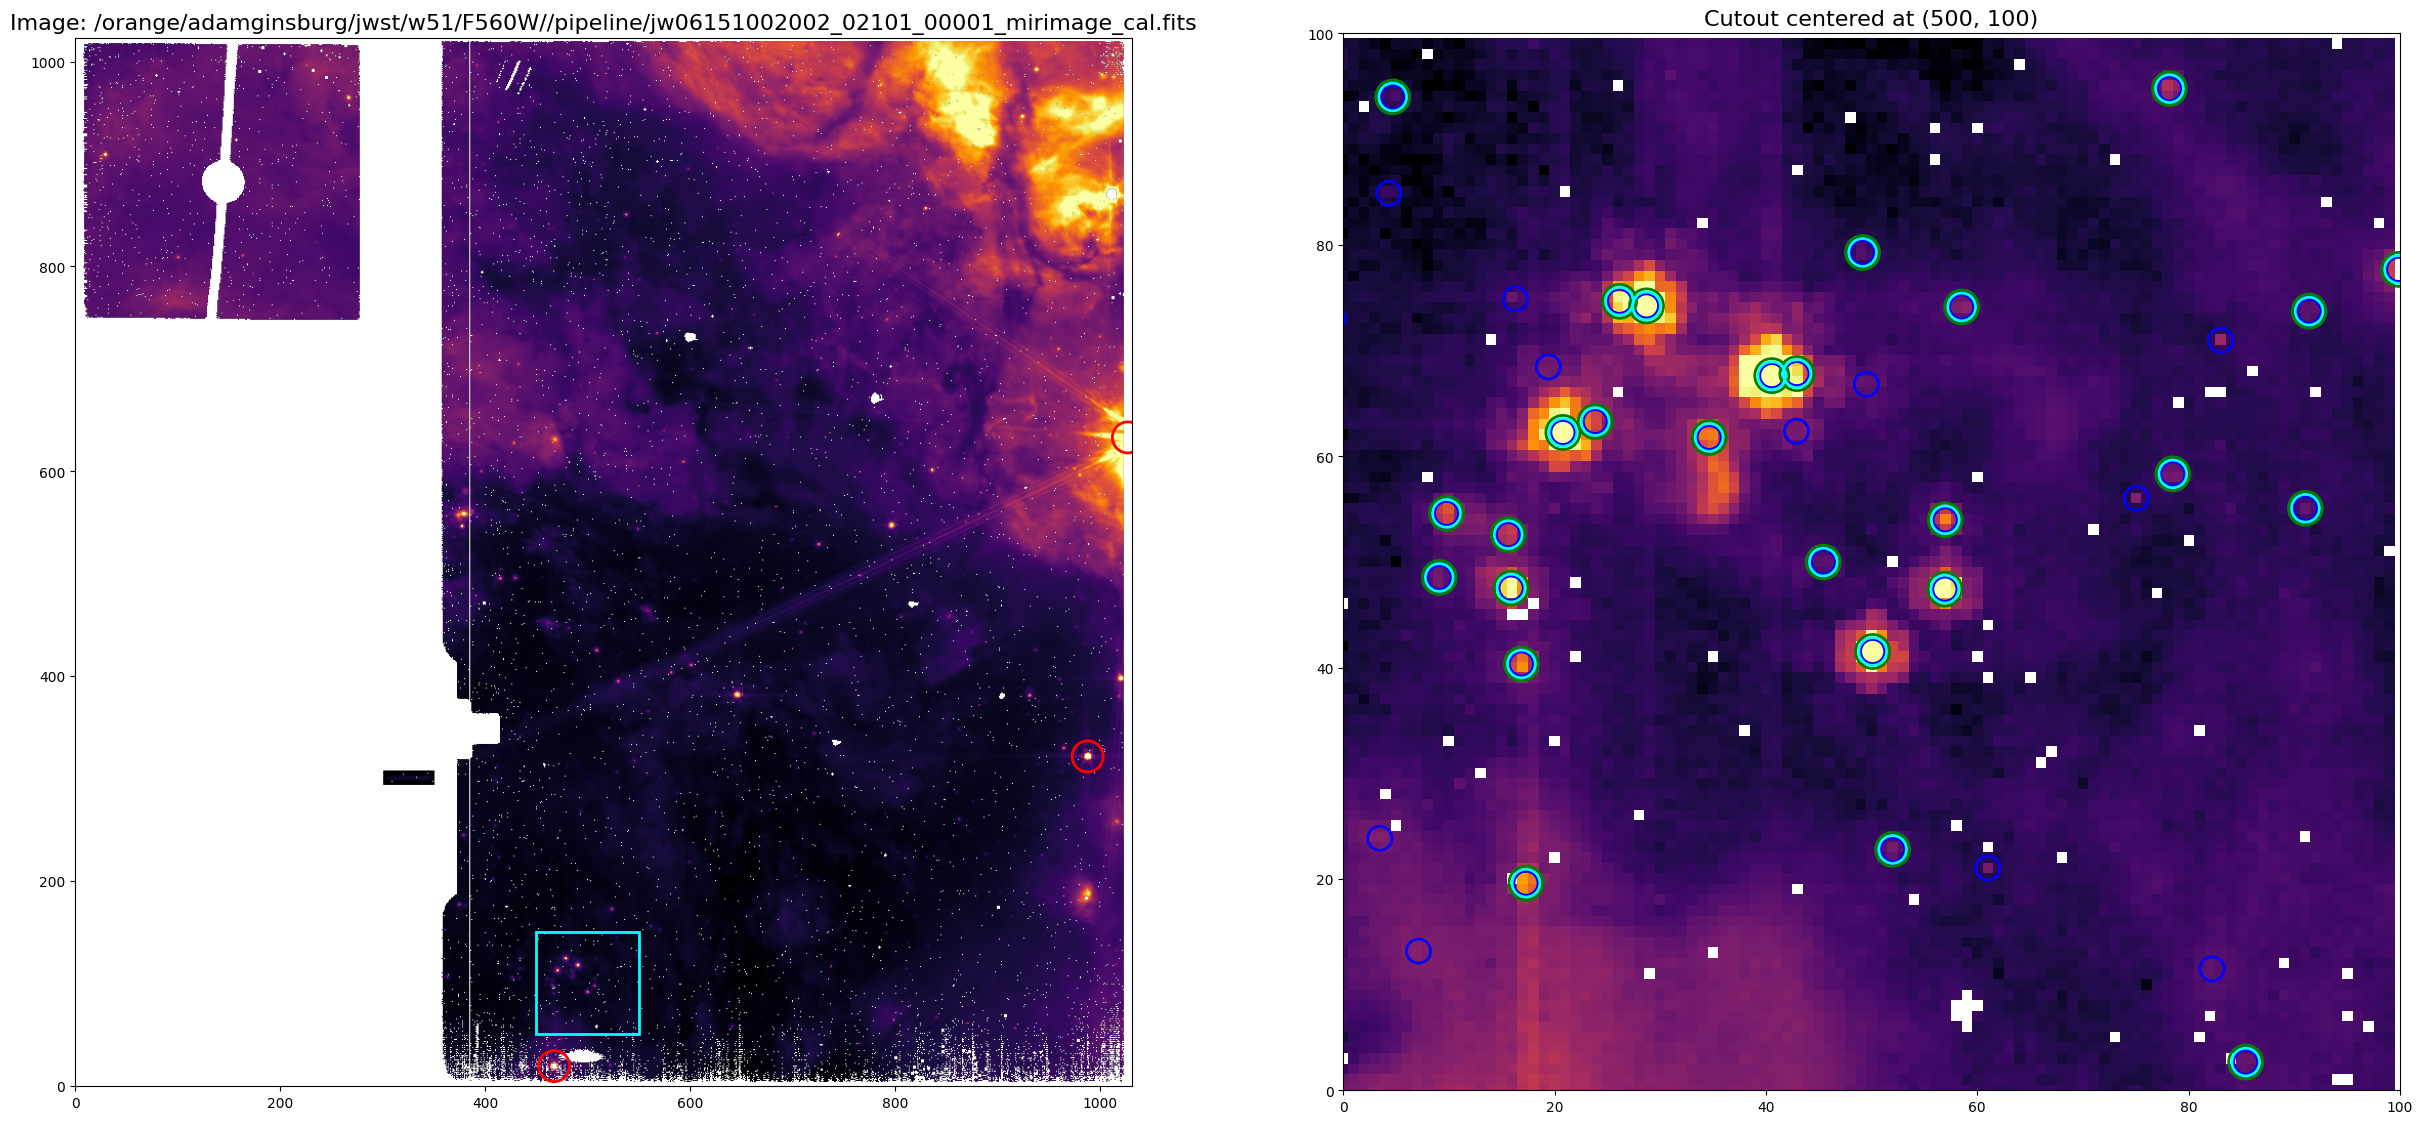

In [4]:
data, err, cutout = main(500, 100, size=100, filter='f560w', module='mirimage', vgroup='2101', expnum='00001', visit='002' )   


/orange/adamginsburg/jwst/w51/F560W/f560w_mirimage_visit002_vgroup02101_exp00001_daophot_combined_with_satstars.fits
/orange/adamginsburg/jwst/w51/F560W/f560w_mirimage_visit002_vgroup02101_exp00001_daophot_basic.fits
/orange/adamginsburg/jwst/w51/F560W/f560w_mirimage_visit002_vgroup02101_exp00001_daophot_refined.fits
/orange/adamginsburg/jwst/w51/F560W//pipeline/jw06151002002_02101_00001_mirimage_cal_satstar_catalog_newnewnewnew.fits
cat_after_sat.colnames ['id', 'local_bkg', 'flux_fit', 'flux_err', 'qfit', 'cfit', 'roundness1', 'roundness2', 'sharpness', 'dra', 'ddec', 'from_sat_catalog', 'skycoord_centroid']


IndexError: index -1 is out of bounds for axis 0 with size 0

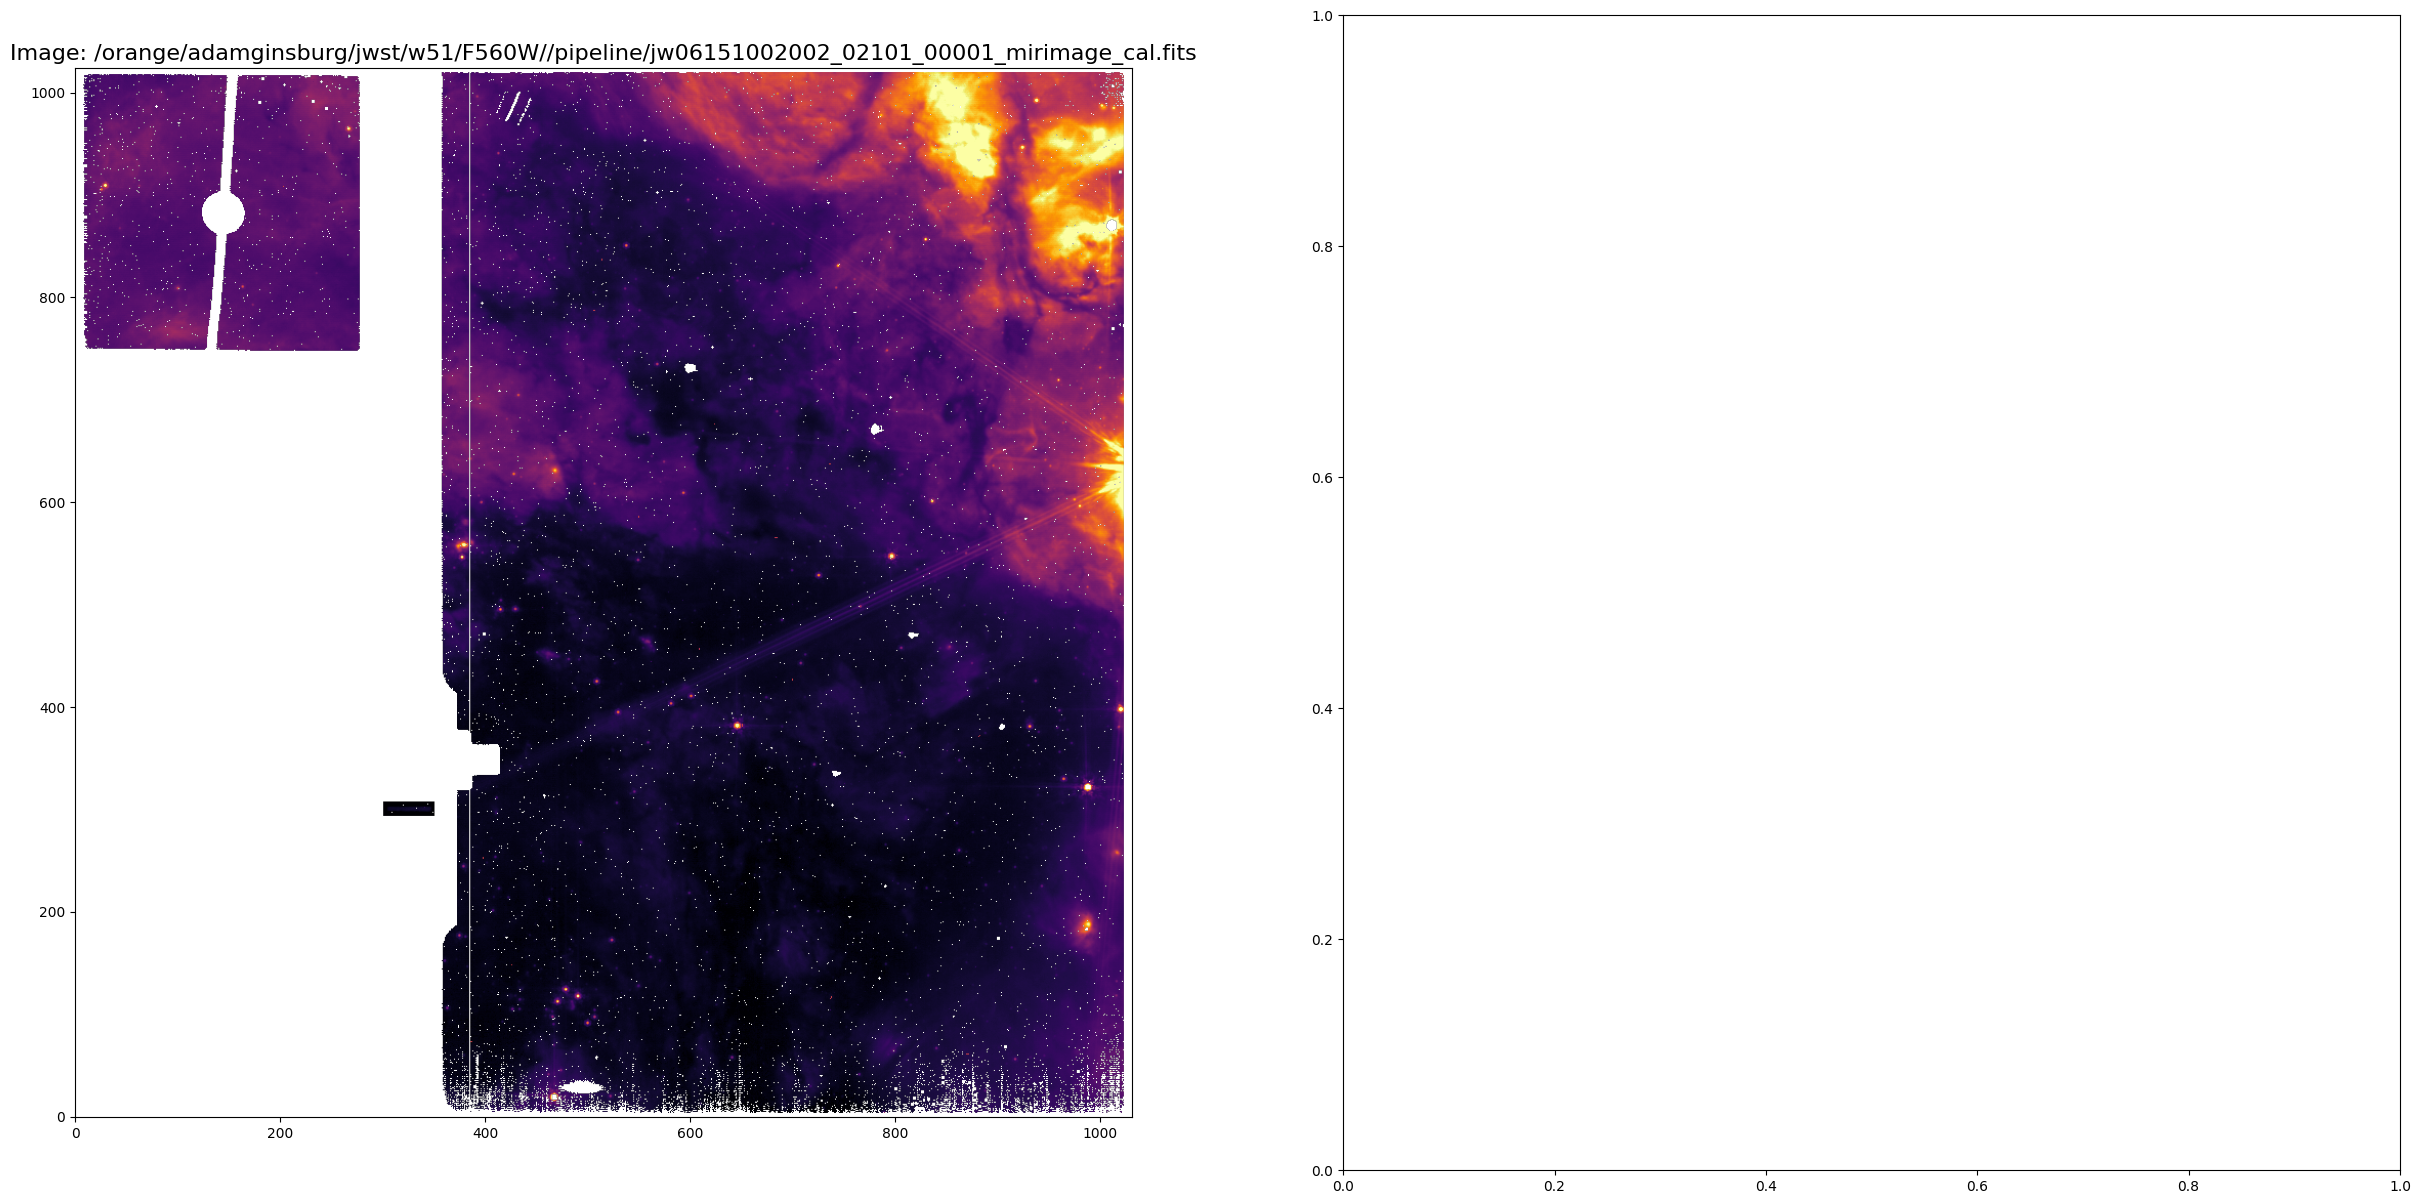

In [5]:
data, err, cutout = main(1100, 500, size=100, filter='f560w', module='mirimage', vgroup='2101', expnum='00001', visit='002' )   


In [ ]:
cutout[28:38, 30:40]

array([[15.160186 , 16.249575 , 14.9915085, 14.425678 , 13.659541 ,
        14.367048 , 14.059262 , 14.051757 , 13.838598 , 14.401141 ],
       [14.113539 , 13.98063  , 14.162744 , 14.270991 , 12.494207 ,
        13.014012 , 13.551801 , 12.567366 , 13.041373 , 13.733128 ],
       [14.071357 , 13.638955 , 13.327762 , 13.860145 , 15.4196415,
        14.701683 , 13.364226 , 13.553509 , 13.270346 , 13.671935 ],
       [13.323484 , 14.445755 , 12.745978 , 13.409693 , 13.003701 ,
        14.020452 , 13.200683 , 12.746159 , 13.492193 , 12.979358 ],
       [14.751743 , 14.54453  , 13.744028 , 13.574232 , 13.7981205,
        13.637994 , 13.585927 , 13.851142 , 12.909955 , 12.157024 ],
       [15.15909  , 14.334926 , 13.3249035, 13.358807 , 13.724272 ,
        14.013324 , 12.978269 , 12.880288 , 12.859489 , 12.493225 ],
       [14.673138 , 13.747855 , 13.376455 , 12.945877 , 13.017283 ,
        12.764871 , 13.160927 , 13.606114 ,        nan, 12.720552 ],
       [12.746964 , 13.275393 , 13.849164

In [ ]:
from astropy.convolution import convolve, Gaussian2DKernel
kernel = Gaussian2DKernel(x_stddev=1)
smoothed = convolve(cutout, kernel)
mask = np.isnan(cutout)
cutout[mask] = smoothed[mask]
cutout[28:38, 30:40]


array([[15.160186 , 16.249575 , 14.9915085, 14.425678 , 13.659541 ,
        14.367048 , 14.059262 , 14.051757 , 13.838598 , 14.401141 ],
       [14.113539 , 13.98063  , 14.162744 , 14.270991 , 12.494207 ,
        13.014012 , 13.551801 , 12.567366 , 13.041373 , 13.733128 ],
       [14.071357 , 13.638955 , 13.327762 , 13.860145 , 15.4196415,
        14.701683 , 13.364226 , 13.553509 , 13.270346 , 13.671935 ],
       [13.323484 , 14.445755 , 12.745978 , 13.409693 , 13.003701 ,
        14.020452 , 13.200683 , 12.746159 , 13.492193 , 12.979358 ],
       [14.751743 , 14.54453  , 13.744028 , 13.574232 , 13.7981205,
        13.637994 , 13.585927 , 13.851142 , 12.909955 , 12.157024 ],
       [15.15909  , 14.334926 , 13.3249035, 13.358807 , 13.724272 ,
        14.013324 , 12.978269 , 12.880288 , 12.859489 , 12.493225 ],
       [14.673138 , 13.747855 , 13.376455 , 12.945877 , 13.017283 ,
        12.764871 , 13.160927 , 13.606114 , 13.330199 , 12.720552 ],
       [12.746964 , 13.275393 , 13.849164

NameError: name 'DAOStarFinder' is not defined

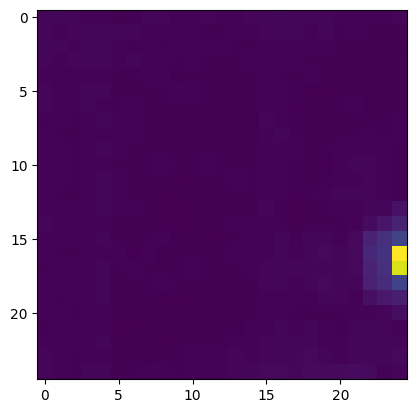

In [ ]:
plt.imshow(cutout[25:50, 25:50])
daofind_tuned = DAOStarFinder(threshold=4 * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=5.0, roundlo=-5.0,
                                  sharplo=0.10, sharphi=1.90)

fin = daofind_tuned.find_stars(cutout[25:50, 25:50], mask=mask)
plt.scatter(fin['xcentroid'], fin['ycentroid'], edgecolor='red', facecolor='none')
fin